In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
from pinns.prelude import *
from pinns.domain import Sphere
from pinns.calc import divergence
from pinns.krr import krr, rbf
from pinns.elm import elm
from pinns.pde import poisson_dirichlet_qp_mc, poisson_dirichlet_ecqp_mc
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [106]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(10))
x_bnd = domain.transform_bnd(x_bnd)

x_support_dom = x_dom[:2**8]
x_support_bnd = x_bnd[:2**6]


In [131]:
from dataclasses import field
from chex import dataclass
from jaxopt.linear_solve import solve_normal_cg

@dataclass(frozen=True)
class StrayField:
    weights: flax.core.FrozenDict
    h: Callable
    l: Callable
    
    #@partial(jit, static_argnums=0)
    def __call__(self, x):
        l = self.l(x)
        h = self.h(x)
        phi1 = l * h @ self.weights['phi1']
        phi2 = l * h @ self.weights['phi2'] + h @ self.weights['g']
        return phi1 + phi2

@partial(jit, static_argnums=(0,1,2))
def _solve_stray_field(h, l, m, x_dom, x_bnd, surface_area, params0=None, **solver_kwargs):
    u = lambda x: l(x) * h(x)
    dk = vmap(jacfwd(u))(x_dom)
    if params0 is None:
        params0 = zeros((dk.shape[1],))
    M = vmap(m)(x_dom)
    p1 = solve_normal_cg(lambda x: jnp.tensordot(dk, x, (1, 0)), M, init=params0, **solver_kwargs)
    phi1 = lambda x: u(x) @ p1

    n = lambda x: -grad(l)(x)
    def phi2_solution_mc(x, x_bnd, A):
        eps = 1e-7
        def g(y):
            return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
        
        dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
        _g = vmap(g)(x_bnd)
        def kernel(dist):
            idx = dist > eps
            newton_kernel = where(idx, 1 / dist, 0.)
            N = jnp.count_nonzero(idx)
            return A / (4 * pi * N) * dot(newton_kernel, _g)

        return vmap(kernel)(dist)

    phi_bnd = phi2_solution_mc(x_bnd, x_bnd, surface_area)

    H = vmap(h)(x_bnd)
    params_g = solve_normal_cg(lambda x: H @ x, phi_bnd, init=params0, ridge=0.001, **solver_kwargs)
    g = lambda x: h(x) @ params_g
    dg = vmap(grad(g))(x_dom)
    p2 = solve_normal_cg(lambda x: jnp.tensordot(dk, x, (1, 0)), -dg, init=params0)
    phi2 = lambda x: u(x) @ p2 + g(x)

    phi = jit(lambda x: phi1(x) + phi2(x))
    return freeze({'phi1': p1, 'phi2': p2, 'g': params_g})

def solve_stray_field(h, l, m, x_dom, x_bnd, surface_area, params0=None, **solver_kwargs):
    weights = _solve_stray_field(h, l, m, x_dom, x_bnd, surface_area, params0=None, **solver_kwargs)
    return StrayField(
        weights=weights,
        h=h, l=l
    )

In [108]:
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("Model")    
    plot_result(lambda x: abs(model(x) - norm(x, axis=-1) + 1), ax2)
    ax2.set_title("abs error")


from jaxopt import EqualityConstrainedQP


def compute_l(h, x_dom, x_bnd):
    Ld = vmap(h)(x_dom)
    Lb = vmap(h)(x_bnd)
    L = concatenate([Lb, Ld])
    Q = L.T @ L
    k = - 2 * jnp.sum(L, axis=0)
    
    eq = EqualityConstrainedQP(
        #refine_regularization=1, refine_maxiter=30, 
        tol=1e-8, maxiter=3000
    )
    p = eq.run(
        params_obj=(Q, k),
        params_eq=(Lb, zeros(len(x_bnd)))
    ).params.primal
    return lambda x: h(x) @ p

weights = array(Sobol(4, seed=12345).random_base2(5))
Wl = (weights[:, :3] * 2 - 1)
bl = (weights[:, 3] * 2 - 1)
hl = lambda x: sin(Wl @ x + bl)


In [139]:

weights = array(Sobol(4, seed=12345).random_base2(9))
W = (weights[:, :3] * 2 - 1)
b = (weights[:, 3] * 2 - 1)

l = compute_l(hl, x_dom, x_bnd)
m = lambda x: x / norm(x)
h = lambda x: elu(W @ x + b)

In [110]:
%timeit -n 10 solve_stray_field(h, l, m, x_dom, x_bnd, 4 * pi)

97.5 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [140]:
phi_nn = vmap(solve_stray_field(h, l, m, x_dom, x_bnd, 4 * pi))

In [141]:
phi_nn(x_dom)

DeviceArray([-0.27197202, -0.03360581, -0.83288689, ..., -0.3271693 ,
             -0.11436739, -0.57111383], dtype=float64)

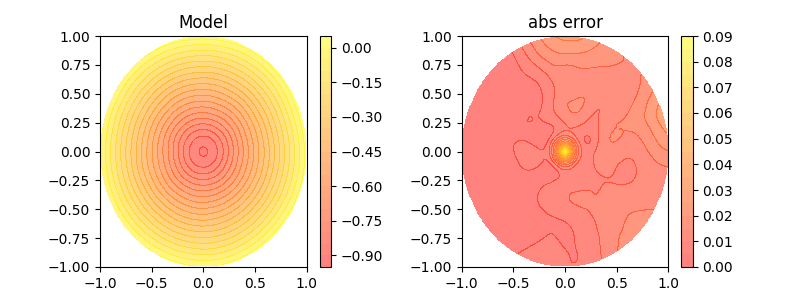

In [142]:

plot_model(phi_nn)
#plot_model(vmap(phi1))

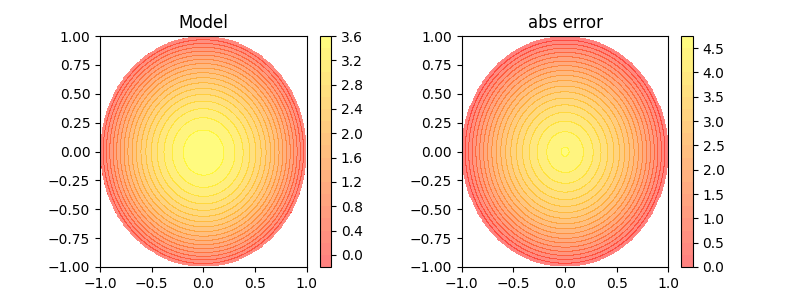

In [143]:
plot_model(vmap(l))

In [38]:
sol = lambda x: norm(x, axis=-1) - 1
sqrt(mean((phi_nn(x_dom) - sol(x_dom))**2))

DeviceArray(0.33663421, dtype=float64)

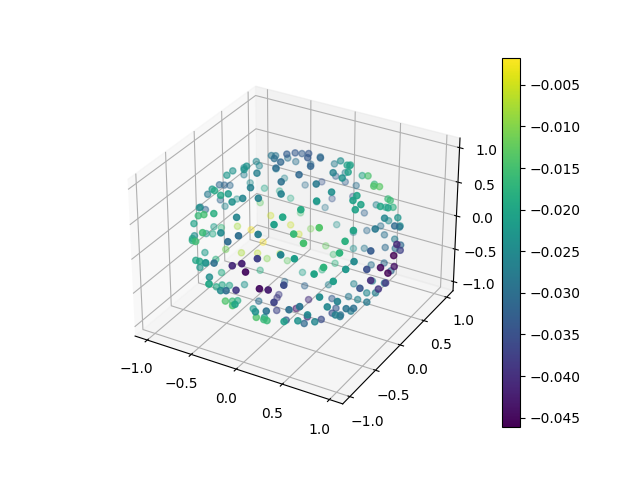

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=phi_nn(x_bnd))
plt.colorbar(p)

In [17]:
net = lambda p, x: h(x) @ p['params']['p']
key = random.PRNGKey(42)
key, subkey = random.split(key, 2)
p0 = random.uniform(key, (2**6,))

tx = optax.adam(0.001)
init_state = TrainState.create(
    apply_fn=net, 
    params=freeze({"p": p0}),
    tx=tx
)

def loss(params, x_dom, x_bnd):
    _dom_loss = lambda x, _, p: (net(p, x) - 1) ** 2
    _bnd_loss = lambda _, x, p: net(p, x) ** 2

    dom_loss = mean(vmap(_dom_loss, (0, None, None))(x_dom, x_bnd, params))
    bnd_loss = mean(vmap(_bnd_loss, (None, 0, None))(x_dom, x_bnd, params))
    _loss = dom_loss + 10000 * bnd_loss
    return _loss, {'dom_loss': dom_loss, 'bnd_loss': bnd_loss}

In [15]:
@jit
def make_batches(rng):
    batches = 24
    k1, k2 = random.split(rng)
    batch_size_dom = x_dom.shape[0] // batches
    batch_size_bnd = x_bnd.shape[0] // batches

    perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    perms_bnd = jax.random.permutation(k2, x_bnd.shape[0])
    perms_bnd = perms_bnd[:batches * batch_size_bnd]  # skip incomplete batch
    perms_bnd = perms_bnd.reshape((batches, batch_size_bnd))

    return x_dom[perms_dom, :], x_bnd[perms_bnd, :]

In [16]:
from pinns.opt import run_epoch

#state = init_state
for epoch in range(0, 2000):
    key, subkey = random.split(key)
    data = make_batches(subkey)
    state, epoch_metrics = run_epoch(state, loss, data)
    if epoch % 100 == 0:
        epoch_metrics = tree_map(mean, epoch_metrics)
        print(f"train epoch: {epoch}, dom_loss: {epoch_metrics['dom_loss']:.4e}, bnd_loss: {epoch_metrics['bnd_loss']:.4e}")

#params1 = {'params': state.params}

NameError: name 'state' is not defined